In [1]:
import math
import numpy as np
from qiskit import QuantumCircuit
from qiskit.visualization import plot_distribution
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit.primitives import StatevectorSampler
import qiskit.quantum_info as qi
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler import StagedPassManager
from qiskit_ibm_runtime import IBMBackend, SamplerOptions
from qiskit_ibm_runtime.fake_provider import FakeBrisbane
import itertools

In [8]:
# unoptimized encoder
def n_encoder(n: int, states: list[str]) -> QuantumCircuit:
    """
    Put n qubits into an equal superposition of states
    """
    encoder = QuantumCircuit(n)

    n_control_bits = math.floor(math.log2(len(states)))
    control_bits = [i for i in range(n-1, n-1-n_control_bits, -1)]
    
    encoder.h(control_bits)
    encoder.barrier()

    for state in states:
        state = state[::-1]

        if not '1' in state[:n - n_control_bits]:
            continue

        x_needed = len([cb for cb in control_bits if state[cb] == '0']) > 0
        if x_needed:
            encoder.x([cb for cb in control_bits if state[cb] == '0'])

        for j, qb in enumerate(state[:n - n_control_bits]):
            if qb == '1':
                encoder.mcx(control_bits, j)

        if x_needed:
            encoder.x([cb for cb in control_bits if state[cb] == '0'])
        
        encoder.barrier()
        
    return encoder

In [9]:
# automatic optimization by qiskit
def n_encoder_statevector(n: int, states: list[str]) -> QuantumCircuit:
    positions = [int(binary_string, 2) for binary_string in states]
    psi = np.zeros((2**n))
    psi[positions] = np.sqrt(1/len(states))
    sv = qi.Statevector(psi)

    c = QuantumCircuit(5)
    c.initialize(sv)
    return c

In [2]:
def get_qc_characteristics(qc):
    depth = qc.depth()
    num_qubits = qc.num_qubits
    ops = qc.count_ops()
    num_multi_qubit_ops = qc.num_nonlocal_gates()
    d = {"depth":depth, "num_qubits":num_qubits, "ops":ops, "num_multi_qubit_ops": num_multi_qubit_ops}
    print(d)

In [3]:
def simulate(circuit: QuantumCircuit):
    sampler = StatevectorSampler()
    result = sampler.run([circuit]).result()
    dist = result[0].data.meas.get_counts()
    return dist

In [4]:
def real_sampler(circuit: QuantumCircuit, pm: StagedPassManager, backend: IBMBackend):
    circuit_isa = pm.run(circuit)
    get_qc_characteristics(circuit_isa)
    sampler = Sampler(mode=backend)
    sampler.options.dynamical_decoupling.enable = True
    sampler.options.dynamical_decoupling.sequence_type = 'XX'
    sampler.options.twirling.enable_gates = True
    sampler.options.twirling.enable_measure = True
    sampler.options.default_shots = 10_000
    result = sampler.run([circuit_isa]).result()
    dist = result[0].data.meas.get_counts()
    return dist


In [23]:
n_qubits = 5
states = ['00010', '00110', '01010', '01111', '10000', '10100', '11000', '11101'] # the first 3 bits identify the experiment, the last two contain the particles count
#states = ['00010', '00110', '01010', '01111', '10000', '10100', '11011', '11101']

In [6]:
service = QiskitRuntimeService(channel="ibm_quantum")
#backend = service.least_busy(operational=True, simulator=False)
backend = FakeBrisbane()#service.backend('ibm_brisbane')
print(backend.name)
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)

fake_brisbane


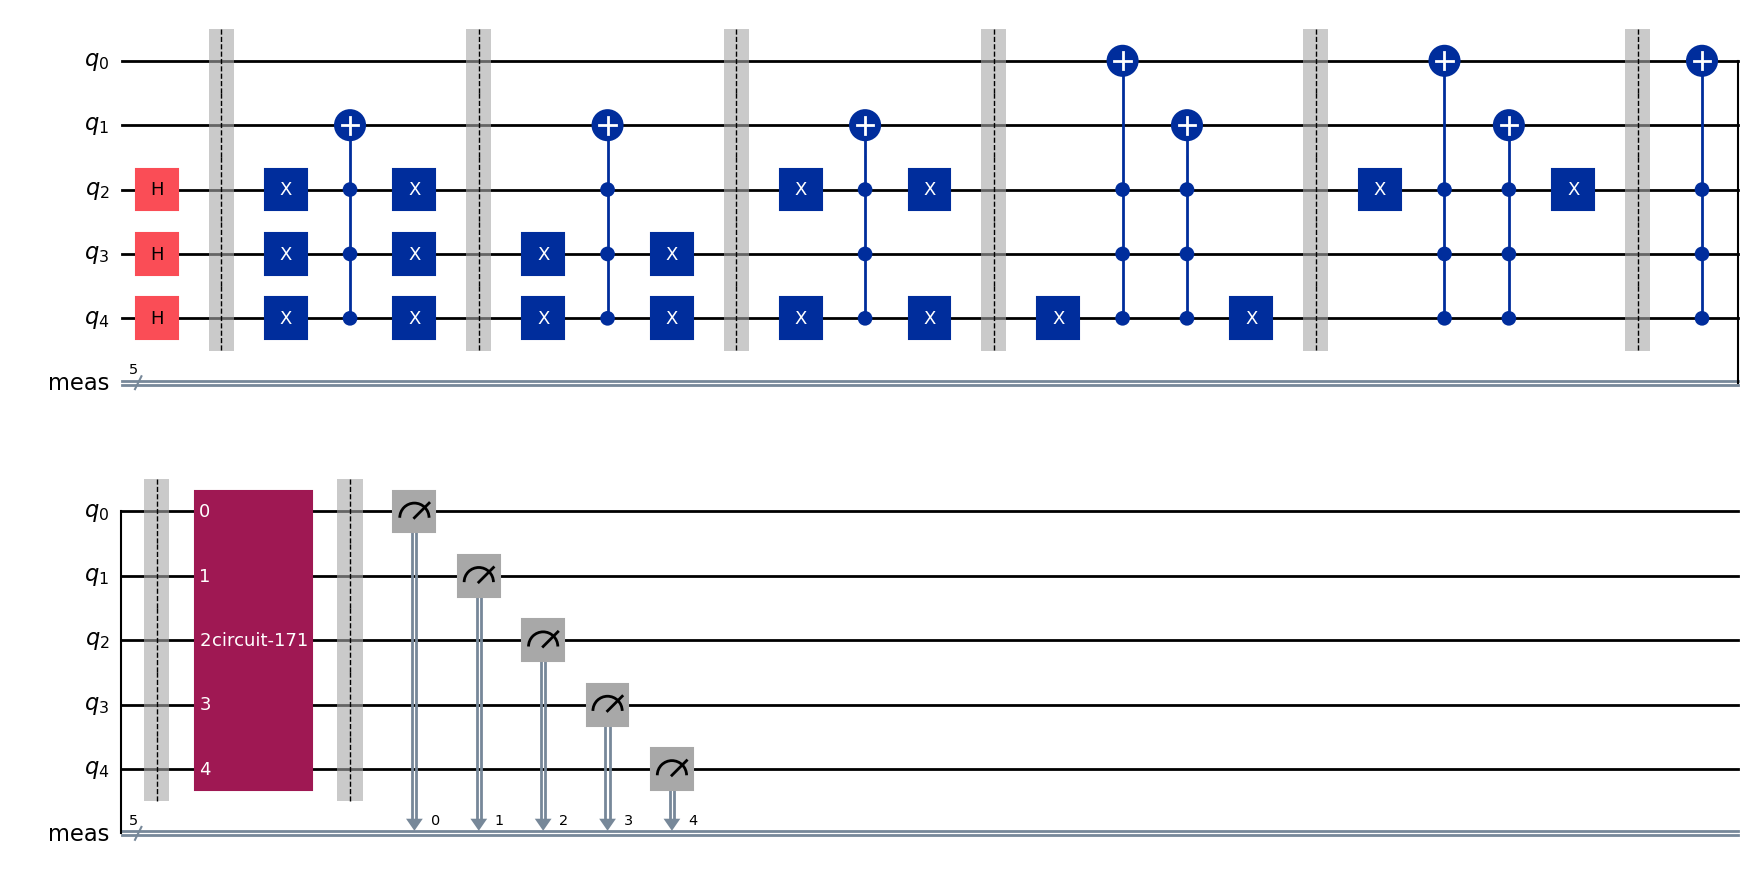

In [10]:
##### unoptimized

circuit = QuantumCircuit(n_qubits)
circuit.compose(n_encoder(n_qubits, states), inplace=True)

oracle = QuantumCircuit(n_qubits)
oracle.cz(0, 1)

zor = QuantumCircuit(n_qubits)
zor.x([i for i in range(n_qubits)])
zor.h(0)
zor.mcx([i for i in range(1, n_qubits)], 0)
zor.h(0)
zor.x([i for i in range(n_qubits)])

grover_block = QuantumCircuit(n_qubits)
grover_block.compose(oracle, inplace=True)
grover_block.barrier()
grover_block.h([i for i in range(n_qubits)])
grover_block.barrier()
grover_block.compose(zor, inplace=True)
grover_block.barrier()
grover_block.h([i for i in range(n_qubits)])
grover_block.barrier()
grover_block.barrier()

optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(8 / 2**n_qubits)))
)

circuit.compose(grover_block.power(optimal_num_iterations), inplace=True)

circuit.measure_all()
isa_unoptimized = pm.run(circuit)
circuit.draw(output="mpl", style="iqp")

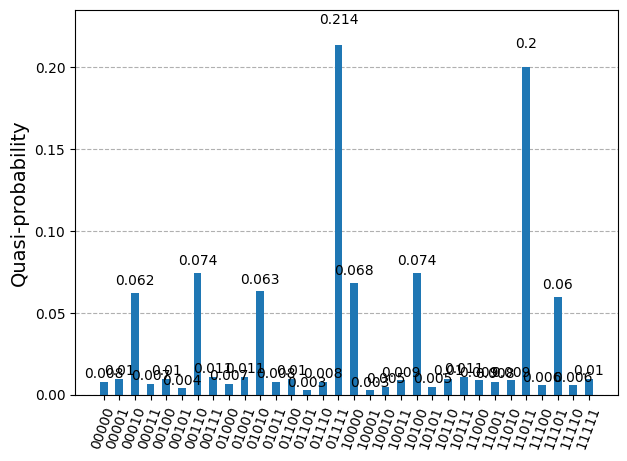

In [11]:
plot_distribution(simulate(circuit))

In [6]:
plot_distribution(real_sampler(circuit, pm))

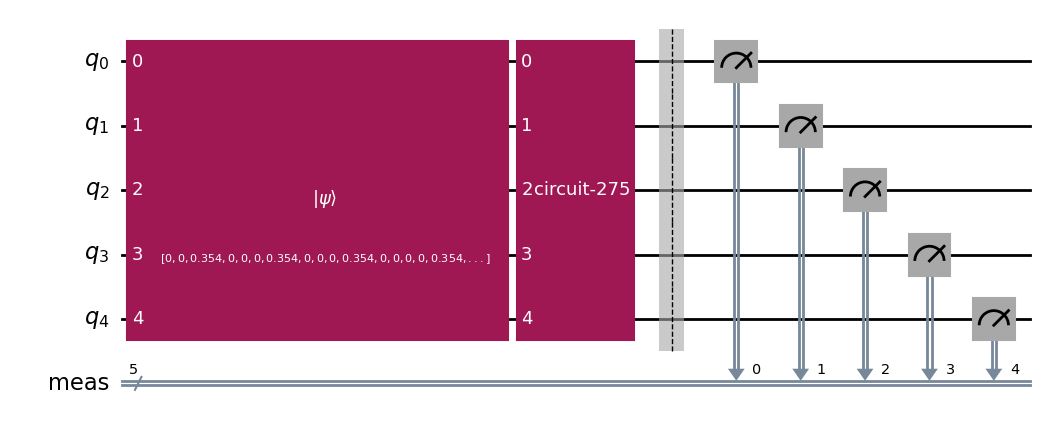

In [12]:
##### optimization I

circuit = QuantumCircuit(n_qubits)
circuit.compose(n_encoder_statevector(n_qubits, states), inplace=True)

oracle = QuantumCircuit(n_qubits)
oracle.cz(0, 1)

zor = QuantumCircuit(n_qubits)
zor.x([i for i in range(n_qubits)])
zor.h(0)
zor.mcx([i for i in range(1, n_qubits)], 0)
zor.h(0)
zor.x([i for i in range(n_qubits)])

grover_block = QuantumCircuit(n_qubits)
grover_block.compose(oracle, inplace=True)
grover_block.barrier()
grover_block.h([i for i in range(n_qubits)])
grover_block.barrier()
grover_block.compose(zor, inplace=True)
grover_block.barrier()
grover_block.h([i for i in range(n_qubits)])
grover_block.barrier()
grover_block.barrier()

optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(8 / 2**n_qubits)))
)

circuit.compose(grover_block.power(optimal_num_iterations), inplace=True)

circuit.measure_all()
isa_opt1 = pm.run(circuit)
circuit.draw(output="mpl", style="iqp")

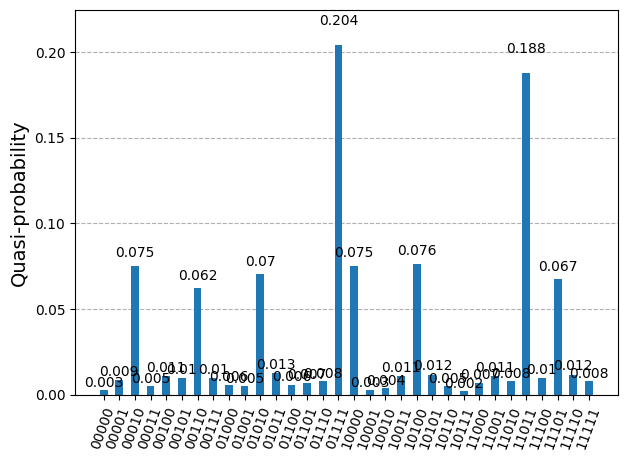

In [13]:
plot_distribution(simulate(circuit))

In [11]:
plot_distribution(real_sampler(circuit, pm, backend))

In [21]:
# custom optimization based on common features

def _get_mcxs(states: list[str], n_qubits: int, n_control_bits: int, m: int) -> tuple[set[tuple[int]]]:
    mcxs_1 = set() # set that will contain qubit indexes for a mcx gate (control on identification bits with a 0 in same positions, target on count bits that have a 1) 
    mcxs_0 = set() # set that will contain qubit indexes for a mcx gate (control on identification bits with a 1 in same positions, target on count bits that have a 1) 

    for i, s in enumerate(states): # control ones
        control_ones_indexes = [i for i, qb in enumerate(s[:n_control_bits]) if qb == '1']
        if len(control_ones_indexes) < m:
            continue

        control_ones_indexes_groups = list(itertools.combinations(control_ones_indexes, m))

        target_ones_indexes = [i + n_control_bits for i, qb in enumerate(s[n_control_bits:]) if qb == '1']

        for gi in control_ones_indexes_groups:
            have_1_in_group_positions = [state for state in states if state != s and all([state[k] == '1' for k in gi])]
            for ti in target_ones_indexes:
                have_1_in_target_position = [state for state in have_1_in_group_positions if state[ti] == '1']
                if len(have_1_in_group_positions) == len(have_1_in_target_position):
                    mcx = [k for k in gi]
                    mcx.append(ti)
                    mcxs_1.add(tuple(mcx))

    for i, s in enumerate(states): # control zeros
        control_zeros_indexes = [i for i, qb in enumerate(s[:n_control_bits]) if qb == '0']
        if len(control_zeros_indexes) < m:
            continue

        control_zeros_indexes_groups = list(itertools.combinations(control_zeros_indexes, m))

        target_ones_indexes = [i + n_control_bits for i, qb in enumerate(s[n_control_bits:]) if qb == '1']
        for gi in control_zeros_indexes_groups:
            have_0_in_group_positions = [state for state in states if state != s and all([state[k] == '0' for k in gi])]
            for ti in target_ones_indexes:
                have_1_in_target_position = [state for state in have_0_in_group_positions if state[ti] == '1']
                if len(have_0_in_group_positions) == len(have_1_in_target_position):
                    mcx = [k for k in gi]
                    mcx.append(ti)
                    mcxs_0.add(tuple(mcx))
    return mcxs_1, mcxs_0

def _common_features(states: list[str], n_qubits: int, n_control_bits: int, encoder: QuantumCircuit) -> list[str]:
    """
    For every possible number of control bits, find and apply the mcx gates that modify the biggest possible number of states at once
    """
    n_controls = 1
    max_n_controls = n_control_bits - 1

    while True:
        mcxs_1, mcxs_0 = _get_mcxs(states, n_qubits, n_control_bits, n_controls)

        if len(mcxs_0) + len(mcxs_1) == 0:
            if n_controls == max_n_controls:
                break
            else:
                n_controls += 1
        else:
            n_controls = min(1, n_controls-1)

        for m in mcxs_1:
            m = list(m)

            m_qisqit_indexing = [n_qubits - 1 - j for j in m]
            encoder.mcx(m_qisqit_indexing[:-1], m_qisqit_indexing[-1])

            for i, s in enumerate(states):
                are_control_ones = [s[j] == '1' for j in m[:-1]]
                if all(are_control_ones):
                    s = list(s)
                    s[m[-1]] = '0'
                    states[i] = ''.join(s)

    
        for m in mcxs_0:
            m = list(m)

            m_qisqit_indexing = [n_qubits - 1 - j for j in m]
            encoder.x(m_qisqit_indexing[:-1])
            encoder.mcx(m_qisqit_indexing[:-1], m_qisqit_indexing[-1])
            encoder.x(m_qisqit_indexing[:-1])

            for i, s in enumerate(states):
                are_control_zeros = [s[j] == '0' for j in m[:-1]]
                if all(are_control_zeros):
                    s = list(s)
                    s[m[-1]] = '0'
                    states[i] = ''.join(s)
    
    return states

def n_encoder_opt(n: int, states: list[str]) -> QuantumCircuit:
    """
    Put n qubits into an equal superposition of states
    """
    encoder = QuantumCircuit(n)

    n_control_bits = math.floor(math.log2(len(states)))
    control_bits = [i for i in range(n-1, n-1-n_control_bits, -1)]
    
    encoder.h(control_bits)
    encoder.barrier()

    states = _common_features(states, n, n_control_bits, encoder)

    encoder.barrier()

    states = [s[::-1] for s in states]
    for state in states: # apply the mcx gates that couldn't be optimized because of unique characteristics of states

        if not '1' in state[:n - n_control_bits]:
            continue

        x_needed = len([cb for cb in control_bits if state[cb] == '0']) > 0
        if x_needed:
            encoder.x([cb for cb in control_bits if state[cb] == '0'])

        for j, qb in enumerate(state[:n - n_control_bits]):
            if qb == '1':
                encoder.mcx(control_bits, j)

        if x_needed:
            encoder.x([cb for cb in control_bits if state[cb] == '0'])
        
        encoder.barrier()
        
    return encoder

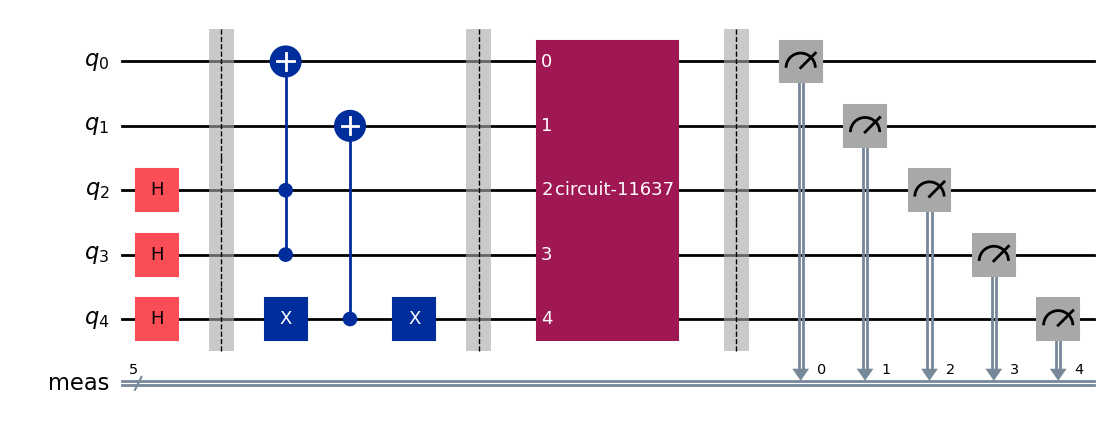

In [24]:
##### optimized II

circuit = QuantumCircuit(n_qubits)
circuit.compose(n_encoder_opt(n_qubits, states), inplace=True)

oracle = QuantumCircuit(n_qubits)
oracle.cz(0, 1)

zor = QuantumCircuit(n_qubits)
zor.x([i for i in range(n_qubits)])
zor.h(0)
zor.mcx([i for i in range(1, n_qubits)], 0)
zor.h(0)
zor.x([i for i in range(n_qubits)])

grover_block = QuantumCircuit(n_qubits)
grover_block.compose(oracle, inplace=True)
grover_block.barrier()
grover_block.h([i for i in range(n_qubits)])
grover_block.barrier()
grover_block.compose(zor, inplace=True)
grover_block.barrier()
grover_block.h([i for i in range(n_qubits)])
grover_block.barrier()
grover_block.barrier()

optimal_num_iterations = math.floor(
    math.pi / (4 * math.asin(math.sqrt(8 / 2**n_qubits)))
)

circuit.compose(grover_block.power(optimal_num_iterations), inplace=True)

circuit.measure_all()
isa_opt2 = pm.run(circuit)
circuit.draw(output="mpl", style="iqp")

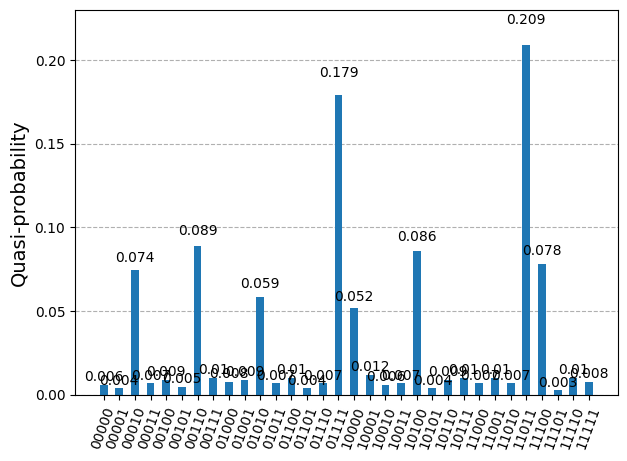

In [16]:
plot_distribution(simulate(circuit))

{'depth': 669, 'num_qubits': 127, 'ops': OrderedDict([('rz', 583), ('sx', 362), ('ecr', 123), ('x', 17), ('barrier', 9), ('measure', 5)]), 'num_multi_qubit_ops': 123}


/home/davide/Desktop/davide/python/quantum/qgss24/qss/lib/python3.10/site-packages/qiskit_ibm_runtime/fake_provider/local_service.py:337: UserWarning: Options {'dynamical_decoupling': {'enable': True, 'sequence_type': 'XX'}, 'twirling': {'enable_gates': True, 'enable_measure': True}} have no effect in local testing mode.
  warnings.warn(f"Options {options_copy} have no effect in local testing mode.")


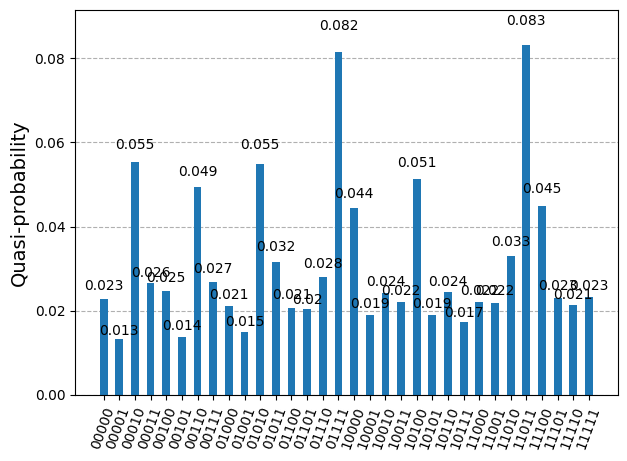

In [17]:
plot_distribution(real_sampler(circuit, pm, backend))

In [18]:
get_qc_characteristics(isa_unoptimized)
get_qc_characteristics(isa_opt1)
get_qc_characteristics(isa_opt2) # the number of gates is sometimes slightly smaller or slightly greater than with the heavy statevector method. 

{'depth': 1464, 'num_qubits': 127, 'ops': OrderedDict([('rz', 1310), ('sx', 822), ('ecr', 286), ('x', 41), ('barrier', 13), ('measure', 5)]), 'num_multi_qubit_ops': 286}
{'depth': 575, 'num_qubits': 127, 'ops': OrderedDict([('rz', 571), ('sx', 346), ('ecr', 120), ('x', 22), ('barrier', 6), ('reset', 5), ('measure', 5)]), 'num_multi_qubit_ops': 120}
{'depth': 669, 'num_qubits': 127, 'ops': OrderedDict([('rz', 584), ('sx', 362), ('ecr', 123), ('x', 16), ('barrier', 9), ('measure', 5)]), 'num_multi_qubit_ops': 123}
